Copyright (c) 2020. Cognitive Scale Inc. All rights reserved.
Licensed under CognitiveScale Example Code [License](https://github.com/CognitiveScale/cortex-certifai-examples/blob/7998b8a481fccd467463deb1fc46d19622079b0e/LICENSE.md)

# Introduction

This is the sixth notebook in this example of how to explain models using Certifai. If you have not already done so, please run the [first notebook](patient-readmission-train.ipynb) to train the models to be explained and the [fifth notebook](patient-readmission-sampling-scan.ipynb) to create explanations using counterfactual sampling.

In this notebook, we will:
1. Load the previously saved explanation reports from the previous notebook
2. Convert the counterfactuals into a dataframe and display them
3. Compare the number of feature changes in the counterfactuals between the previous scans

In [1]:
import numpy as np
import pandas as pd
from pprint import pprint

from certifai.scanner.report_reader import ScanReportReader
from certifai.scanner.explanation_utils import (explanations, construct_explanations_dataframe, counterfactual_changes,
                                                counterfactual_feature_frequency, drop_metadata_columns)
from certifai.scanner.builder import ExplanationType
from IPython.display import display, Markdown
import matplotlib.pyplot as plt

# Loading the Explanations Reports

To load the report, we need to know the use case ID ('readmission') and the scan ID.

List the available use cases, and the scans within the 'readmission' use case.

In [2]:
reader = ScanReportReader("reports")
reader.list_usecases()
scans = reader.list_scans('readmission')
data=[[s['date'], ', '.join(s['reportTypes']), s['id']] for s in scans]
df = pd.DataFrame(data, columns=['date', 'evals', 'scan id']).sort_values(by=['date'], ascending=False)
print(df)

              date        evals       scan id
0  20211012T191107  explanation  9bdb2bc8dfd5
1  20211012T190847  explanation  56c3cf74279e


Below we load the two latest explanation scans. This notebook assumes that it is being run directly after the [previous notebook](patient-readmission-sampling-scan.ipynb). was did not have access to the model. 

In [3]:
def _verify_sampling_scan_without_model(scan):
    scan_id = scan['explanation']['logit']['scan']['scan_id']
    is_sampling = scan['explanation']['logit']['sampling_explanations']
    no_model_access = scan['explanation']['logit'].get('no_model_access', False)
    assert is_sampling and no_model_access, f'Scan {scan_id} did not involve counterfactual sampling without model access! Was the previous notebook run before this?'
    
    
def _verify_sampling_scan_with_model(scan):
    scan_id = scan['explanation']['logit']['scan']['scan_id']
    is_sampling = scan['explanation']['logit']['sampling_explanations']
    no_model_access = scan['explanation']['logit'].get('no_model_access', False)
    assert is_sampling and not no_model_access, f'Scan {scan_id} did not involve counterfactual sampling with model access! Was the previous notebook run before this?'


latest_explanation = df[df.evals == 'explanation'].iloc[0]
scan_without_model_access = reader.load_scan('readmission', latest_explanation['scan id'])
_verify_sampling_scan_without_model(scan_without_model_access)

previous_explanation = df[df.evals == 'explanation'].iloc[1]
scan_with_model_access = reader.load_scan('readmission', previous_explanation['scan id'])
_verify_sampling_scan_with_model(scan_with_model_access)

# Extract the explanations

In this section we'll construct a dataframe containing all of the original instances, and their counterfactuals. We'll then print out the first two for the logit and mlp models.

In [4]:
max_displayed = 1
model = 'logit'
pd.set_option('display.max_columns', None) # print all cols

def display_explanations(df):
    for row in range(1,max_displayed+1):
        df_instances = df[(df['model']==model) & (df['row']==row)]
        df_original = df_instances[df_instances['instance']=='original']
        display(Markdown(f'### Explanation of model {model} prediction row {row}\n'))
        display(Markdown('**Original Instance**'))
        display(df_original)
        orig_prediction=df_original['prediction'].iloc[0]
        display(Markdown(f'**Original Prediction**: {"Readmitted" if orig_prediction == 1 else "Not Readmitted"}'))
        display(Markdown('### Counterfactual Changes'))
        changes = counterfactual_changes(df_instances)
        display(changes)

In [5]:
%matplotlib inline

def plot_histogram(axs, top_10_features, model_id):
    axs.bar(top_10_features.index, top_10_features.values)
    axs.set_xticks(top_10_features.index)
    axs.set_xlabel("Feature Name", fontsize=15)
    axs.set_title(f"Model {model_id}", fontsize=15)
    axs.set_ylabel("Frequency of Change", fontsize=15)
    
def plot_feature_change_frequency(explanation_df):
    feature_freq = counterfactual_feature_frequency(explanation_df)
    top_10_features = feature_freq.nlargest(10)

    fig, (axs1) = plt.subplots(1, 1, figsize=[18,6])
    fig.suptitle('Frequency of feature change', fontsize=20)
    plot_histogram(axs1, top_10_features, model)
    
    fig.tight_layout()
    plt.show()

## Extract the explanations for the scan with model access

Construct the dataframe containing the original instances and the counterfactual instances. Then print out the changed features for the first explained predictions of the logit model.

### Explanation of model logit prediction row 1


**Original Instance**

,model,row,instance,cf_num,cf_type,prediction,fitness,contribution,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race,gender,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
0,logit,1,original,0,original prediction,0,0.0,NaN,35,7,7,0,26,0,0,0,9,AfricanAmerican,Female,Respiratory,Circulatory,Circulatory,None,None,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes


**Original Prediction**: Not Readmitted

### Counterfactual Changes

,instance,cf_num,cf_type,prediction,fitness,number_inpatient
0,original,0,original prediction,0,0.000000,0
0,counterfactual,1,prediction changed,1,1.262901,1


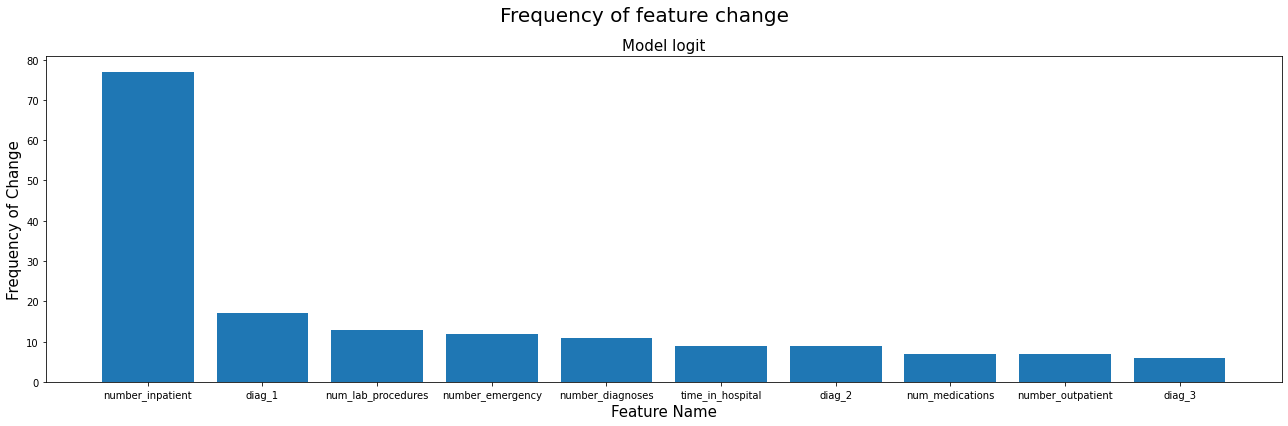

In [6]:
df_with_model_access = construct_explanations_dataframe(explanations(scan_with_model_access))
display_explanations(df_with_model_access)
plot_feature_change_frequency(df_with_model_access)

## Extract the explanations for the scan without model access

Construct the dataframe containing the original instances and the counterfactual instances. Then print out the changed features for the first explained prediction of the logit model.

### Explanation of model logit prediction row 1


**Original Instance**

,model,row,instance,cf_num,cf_type,prediction,fitness,contribution,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race,gender,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
0,logit,1,original,0,original prediction,0.0,0.0,NaN,35,7,7,0,26,0,0,0,9,AfricanAmerican,Female,Respiratory,Circulatory,Circulatory,None,None,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes


**Original Prediction**: Not Readmitted

### Counterfactual Changes

,instance,cf_num,cf_type,prediction,fitness,age,num_lab_procedures,num_medications,number_inpatient,number_diagnoses,diag_2,pioglitazone,insulin
0,original,0,original prediction,0.0,0.000000,35,7,26,0,9,Circulatory,Steady,Steady
0,counterfactual,1,prediction changed,1.0,0.115974,45,36,29,1,8,Respiratory,No,Down


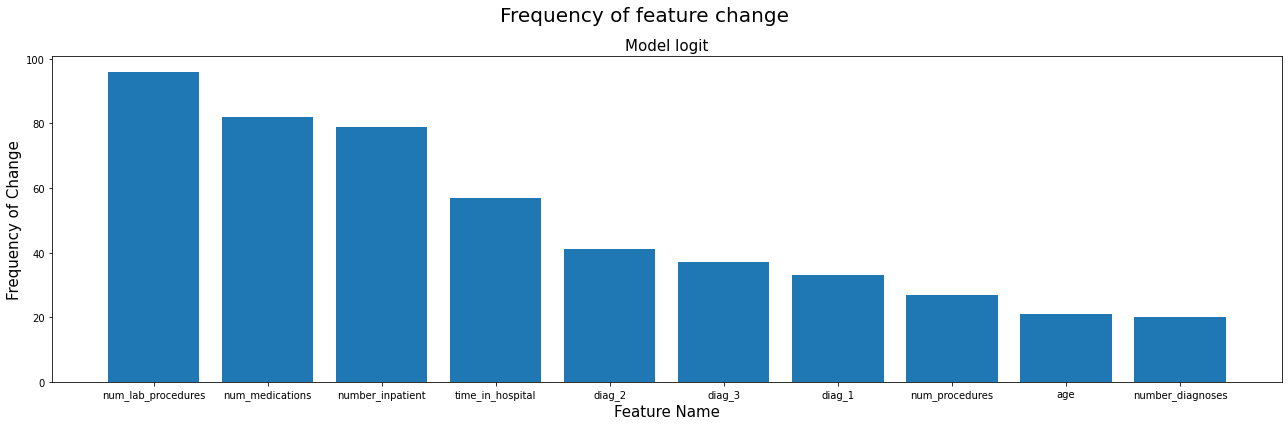

In [7]:
df_without_model_access = construct_explanations_dataframe(explanations(scan_without_model_access))
display_explanations(df_without_model_access)
plot_feature_change_frequency(df_without_model_access)

### Comparing the frequency of feature changes between the two scans

Below we collect the 15 most frequenty changed features from the scan with model access, and plot the frequency of change in both the scan with and without model access to make a direct comparison.

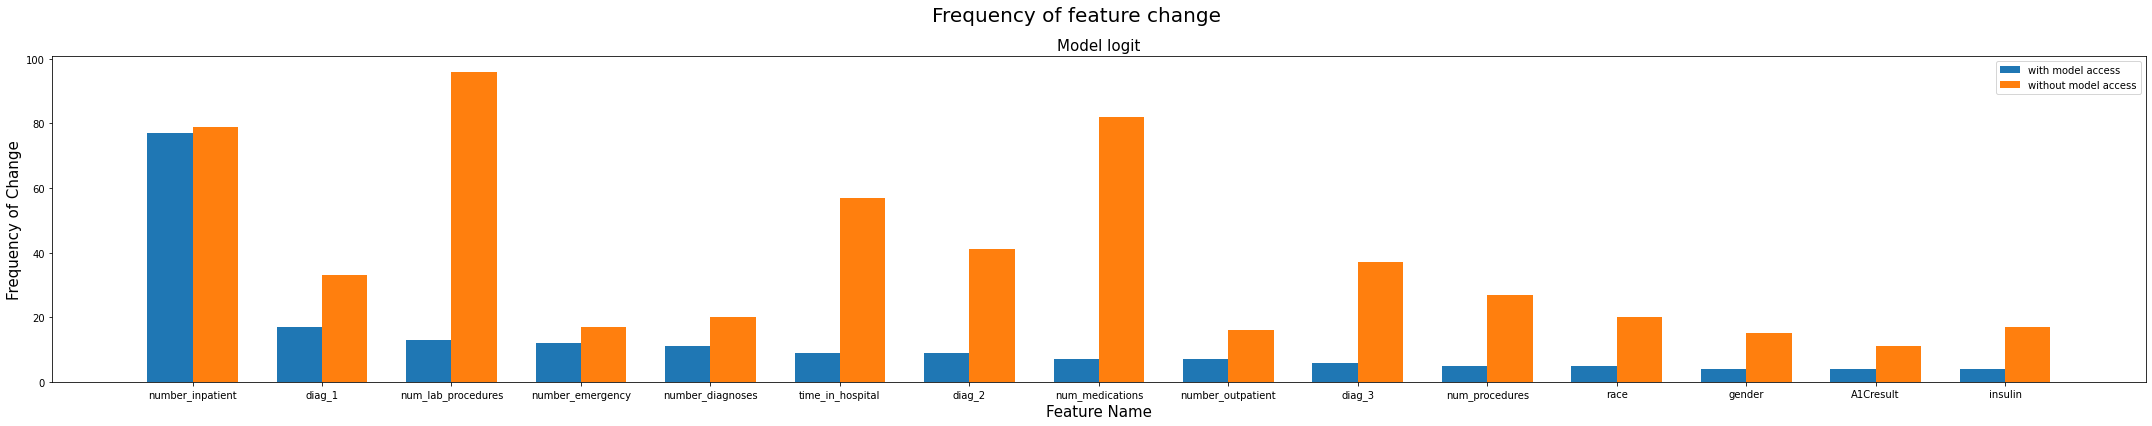

In [8]:
freq_without_model = counterfactual_feature_frequency(df_without_model_access)
freq_with_model = counterfactual_feature_frequency(df_with_model_access)

def plot_histogram_together(axs, model_id):
    n = 15
    x = np.arange(n)  # the label locations
    width = 0.35  # the width of the bars

    # collect top N features from the scan with a model
    top_n_features = freq_with_model.nlargest(n)
    axs.bar(x - width/2, top_n_features.values, width, label='with model access')
    axs.bar(x + width/2, freq_without_model[top_n_features.index.values], width, label='without model access')

    axs.set_xticks(x)
    axs.set_xticklabels(top_n_features.index)
    axs.set_xlabel("Feature Name", fontsize=15)
    axs.set_title(f"Model {model_id}", fontsize=15)
    axs.set_ylabel("Frequency of Change", fontsize=15)
    axs.legend()
    
    
def plot_feature_change_frequency():
    fig, (axs1) = plt.subplots(1, 1, figsize=[30,6])
    fig.suptitle('Frequency of feature change', fontsize=20)
    plot_histogram_together(axs1, model)
    
    fig.tight_layout()
    plt.show()
    
plot_feature_change_frequency()

Notice in the above plot that each feature was changed more often in the scan that did not have model access, compared to the scan that did. This is because when Certifai has access to the model, unnecessary feature changes can be removed from the counterfactual that is found within the dataset. 